In [1]:
import pandas as pd
import numpy as np
import mne
import os

import matplotlib
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy import signal
from scipy.signal import lfilter

In [2]:
# file path to your EEG data
file_path = 'data/0014.txt'

# read in the data using pandas
data = pd.read_csv(file_path, delimiter='\t')

sampling_rate = 1000 # samples per second
notch_freq = 50 #Hz
notch_bw = 2 #Hz

eeg_mask = data.columns != 'EVENT1'

b, a = signal.iirnotch(notch_freq, notch_bw, sampling_rate)
filtered_data = signal.lfilter(b, a, data.loc[:, eeg_mask], axis=0)
filtered_df = data.copy()
filtered_df.loc[:, eeg_mask] = filtered_data
filtered_df

# extract the data as a numpy array
eeg_data = filtered_df.values[:, :-1].T

# create an MNE info object
n_channels = eeg_data.shape[0]
ch_names = ['CH{}'.format(i) for i in range(1, n_channels)] + ['EVENT1']
ch_types = ['eeg'] * (len(ch_names) - 1) + ['stim']
sfreq = 1000
info = mne.create_info(ch_names, sfreq, ch_types)

# create an MNE RawArray object
raw = mne.io.RawArray(eeg_data, info)

# print information about the data
print(raw.info)

Creating RawArray with float64 data, n_channels=28, n_times=275559
    Range : 0 ... 275558 =      0.000 ...   275.558 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: CH1, CH2, CH3, CH4, CH5, CH6, CH7, CH8, CH9, CH10, CH11, CH12, ...
 chs: 27 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 28
 projs: []
 sfreq: 1000.0 Hz
>


In [52]:
# Applying additional filters over the signal
raw.filter(l_freq=1, h_freq=None)
raw.filter(l_freq=None, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.5s finished


<RawArray | 28 x 275559 (275.6 s), ~58.9 MB, data loaded>

In [58]:
events = mne.find_events(raw, stim_channel='EVENT1', shortest_event=0.1, verbose=True)
event_id = {'Stimulus': 2}
tmin = -1  # start time before the event
tmax = 1  # end time after the event
baseline = None  # no baseline correction
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)
print(epochs)

6908 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  26  36  39  42  44  45  46  47  48  49  51  52  53  54
  55  56  57  58  59  60  61  62  68  74  78  98  99 101 102 105 106 107
 110 111 112 114 115 116 117 118 119 120 121 124 125 127 129]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 2001 original time points ...
0 bad epochs dropped
<Epochs |  1 events (all good), -1 - 1 sec, baseline off, ~469 kB, data loaded,
 'Stimulus': 1>


C:\Users\metodi\AppData\Local\Temp\ipykernel_15132\2001483099.py:1: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(raw, stim_channel='EVENT1', shortest_event=0.1, verbose=True)


In [59]:
epochs

Number of events,1
Events,Stimulus: 1
Time range,-1.000 – 1.000 sec
Baseline,off


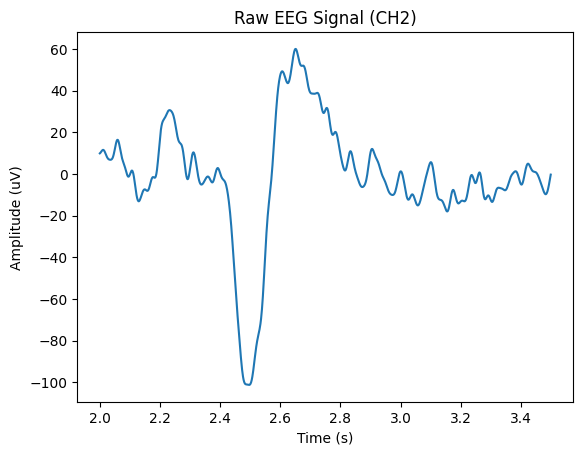

In [60]:
import matplotlib.pyplot as plt

# pick a channel to plot
channel_index = 1
channel_name = raw.ch_names[channel_index]

# select a time range to plot
start_time = 2000
end_time = 3500

# extract the data for the selected channel and time range
data, times = raw[channel_index, start_time:end_time]

# plot the data
fig, ax = plt.subplots()
ax.plot(times, data.T)
ax.set(title=f'Raw EEG Signal ({channel_name})', xlabel='Time (s)', ylabel='Amplitude (uV)')
plt.show()


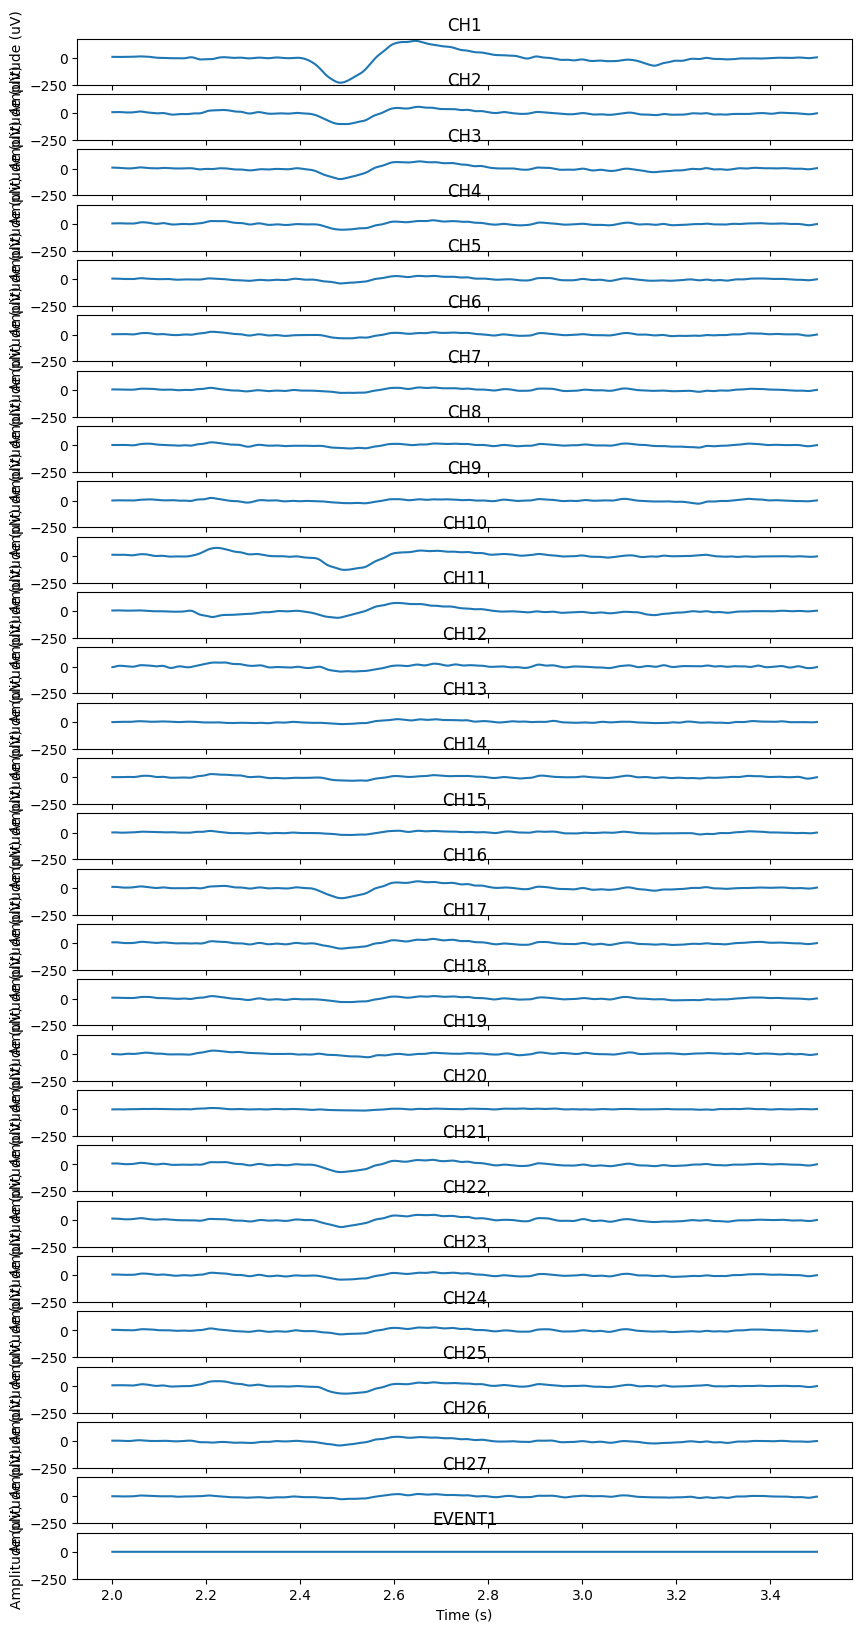

In [61]:
import matplotlib.pyplot as plt

# select a time range to plot
start_time = 2000
end_time = 3500

# plot all channels
fig, axes = plt.subplots(nrows=len(raw.ch_names), sharex=True, sharey=True, figsize=(10, 20))
for channel_index, channel_name in enumerate(raw.ch_names):
    # extract the data for the selected channel and time range
    data, times = raw[channel_index, start_time:end_time]
    # plot the data
    axes[channel_index].plot(times, data.T)
    axes[channel_index].set(title=channel_name, ylabel='Amplitude (uV)')
axes[-1].set(xlabel='Time (s)')
plt.show()


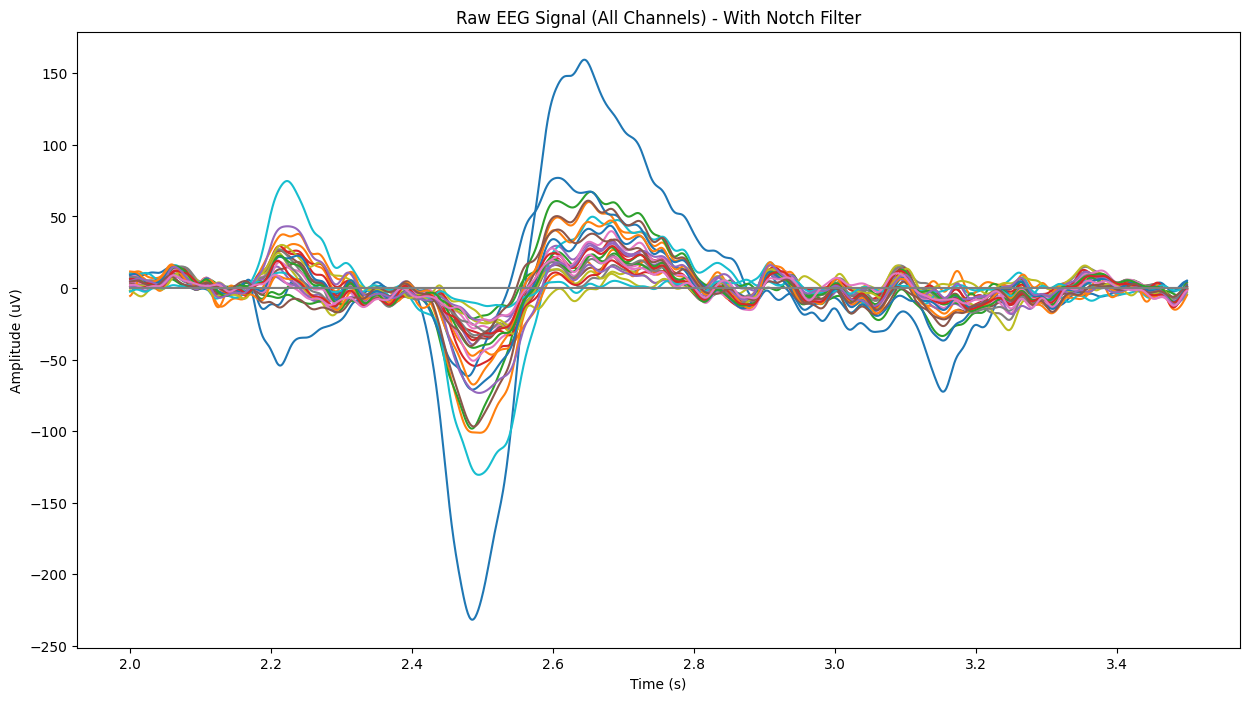

In [62]:
import matplotlib.pyplot as plt

# select a time range to plot
start_time = 2000
end_time = 3500

# extract the data for the selected time range
data, times = raw[:, start_time:end_time]

# plot the data
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(times, data.T)
ax.set(title='Raw EEG Signal (All Channels) - With Notch Filter', xlabel='Time (s)', ylabel='Amplitude (uV)')
plt.show()

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 2001 original time points ...
0 bad epochs dropped


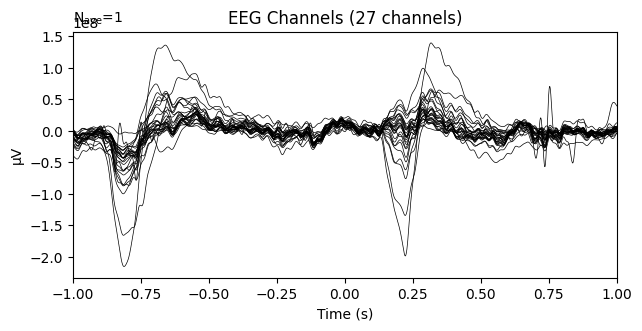

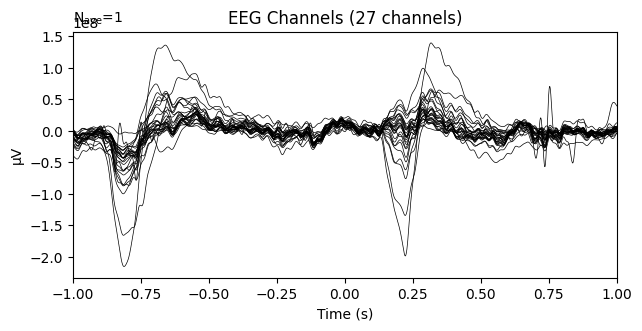

In [63]:
# extract epochs from the raw data
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True)
# compute the evoked response
evoked = epochs.average()
# plot the evoked response
evoked.plot(time_unit='s', picks='eeg', titles=dict(eeg='EEG Channels'))

In [ ]:
from mne.time_frequency import tfr_morlet

frequencies = np.arange(6, 30, 2)  # frequency range
n_cycles = 3  # number of cycles in Morlet wavelet
power = tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False)
power.plot_topo(baseline=(-0.5, 0), mode='zscore', title='Time-Frequency Plot')